In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import umap
from colour import Color
from collections import Counter
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from group_analysis import do_kmeans_clustering, plot_clusters, log_and_scale, colour_list, display_group_kw_combis
from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from clustering import reduce_features, make_elbow_plot, compare_binary_normed_feature_embeddings, mc_list, plot_bin_and_norm_clusters, plot_contingency_matrix, calculate_cluster_lrs

from language_change_methods.features import get_tok_counts, function_words, combine_counts, make_feature_matrix
from language_change_methods.utility_functions import basic_preprocessing, get_ngram_example, get_text_example_of_pos, make_ngram_concordance, make_pos_concordance

from sklearn.cluster import KMeans, SpectralClustering, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk import ngrams as make_ngrams

from settings import TFES_FP as DB_FP, TFES_TOK_FP
GRAPH_DIR = "./Graphs"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%time
all_posts = load_posts(DB_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

fe_posts = all_posts.query("board_id in @flat_earth_boards")
ot_posts = all_posts.query("board_id in @other_boards")

toks = {int(x[0]): x[1] for x in load_toks(TFES_TOK_FP)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(fe_posts.index)]

pos = {int(x[0]): x[1] for x in load_pos(TFES_TOK_FP)}
pos = pd.Series(pos)
pos = pos[pos.index.isin(fe_posts.index)]
pos = pos.loc[toks.index]

fe_posts = fe_posts.loc[toks.index]

Wall time: 31.5 s


In [4]:
with open("../data/user_metagroup.json") as group_file:
    meta_clusts = pd.Series(json.load(group_file))
    meta_clusts.index = meta_clusts.index.astype("float64")

In [5]:
post_lengths = toks.apply(len)
user_n_words = post_lengths.groupby(fe_posts["poster_id"]).sum()
posts_per_user = fe_posts.groupby("poster_id").size()

over_100 = posts_per_user[posts_per_user > 100]
print(f"{len(over_100)} with > 100 posts")

top_20 = posts_per_user.sort_values(ascending=False).head(20)
print(f"{len(top_20)} in the top 20")

curr_users = meta_clusts[meta_clusts == "Core Community"].index
    
user_n_words = user_n_words.loc[curr_users]
posts_per_user = posts_per_user.loc[curr_users]

curr_posts = fe_posts.query("poster_id in @curr_users")

# Get colour gradient
colour_gradient = list(Color("red").range_to(Color("blue"),len(curr_users)))
colour_gradient = pd.Series(colour_gradient, index=posts_per_user.loc[curr_users].sort_values(ascending=True).index)
colour_gradient = colour_gradient.loc[curr_users].apply(str)

101 with > 100 posts
20 in the top 20


# Create the user text chunks

In [6]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

def get_chunks(u, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield u, tokens[i:i+chunk_size]

In [7]:
def make_tok_chonks(tokens, chunk_size):
    user_chunks = [[[user, chunk] for user, chunk in get_chunks(user, curr_toks, chunk_size)] for user, curr_toks in tokens.items()]
    user_chunks = merge_lists(user_chunks)
    user_chunks = pd.DataFrame(user_chunks, columns=["User", "Chunk"])
    return user_chunks

In [8]:
CHUNK_SIZE = 1000

In [9]:
%%time
user_toks = toks.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_chunks = make_tok_chonks(user_toks, CHUNK_SIZE)

Wall time: 764 ms


In [10]:
%%time
user_pos = pos.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_pos_chunks = make_tok_chonks(user_pos, CHUNK_SIZE)

Wall time: 1.17 s


# Create the Different Feature Counts

#### BOW

In [11]:
%%time
# Get the counts
bow_counts = {i: get_tok_counts(post) for i, post in user_toks.items()}
bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
top_n = get_top_n_toks(bow_counts.values(), 10000)
bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
bow_counts = pd.Series(bow_counts)

Wall time: 34.8 s


#### Tfidf bow counts

In [12]:
%%time
# Credit for this cell: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
from sklearn.feature_extraction.text import TfidfVectorizer
# If you had counts instead of tokens, you'd use "TfidfTransformer"

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  


tfidf_matrix = tfidf.fit_transform(user_toks)

Wall time: 1.23 s


In [13]:
tfidf_feats = tfidf_matrix[:, np.isin(tfidf.get_feature_names(), top_n)].todense()

#### PoS Trigrams

In [14]:
pos_trigrams = pd.Series([make_ngrams(post, 3) for post in user_pos], index=user_pos.index)
pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])

In [15]:
top_n = [x[0] for x in Counter(merge_lists(pos_trigrams)).most_common(1000)]
pos_tri_counts = pos_trigrams.apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
pos_tri_counts = pd.Series(pos_tri_counts)

In [16]:
# pos_tri_chunks = pd.DataFrame(index=user_pos_chunks.index)
# pos_tri_chunks["User"] = user_pos_chunks["User"]
# pos_tri_chunks["Chunk"] = pos_trigrams

# Create the Feature Matrix

In [17]:
%%time
# Initialise feats to None
bin_feats = None
norm_feats = None

# Make the feature matrix
curr_feat_type = "pos_tri"
SCALE = True
APPLY_PCA = True

if curr_feat_type == "pos_tri":
    curr_counts = pos_tri_counts
    curr_toks = pos_trigrams
elif curr_feat_type == "bow":
    curr_counts = bow_counts
    curr_toks = user_toks
elif curr_feat_type == "tfidf":
    curr_counts = bow_counts
    curr_toks = user_toks
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(tfidf_feats)
    norm_feats = tfidf_feats
    
if bin_feats is None:
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / user_toks.apply(len).values[:,None]

Wall time: 146 ms


#### Scaling

In [18]:
if SCALE:
    norm_feats = StandardScaler().fit_transform(norm_feats)

#### PCA reduction

In [19]:
%%time
from sklearn.decomposition import PCA
pca = PCA(.95)

if APPLY_PCA:
    norm_feats = pca.fit_transform(norm_feats)

Wall time: 125 ms


In [20]:
print(f"{norm_feats.shape[1]} components")

158 components


#### Make 2d embeddings

In [21]:
%%time
norm_embedding = reduce_features(norm_feats)

Wall time: 5.74 s


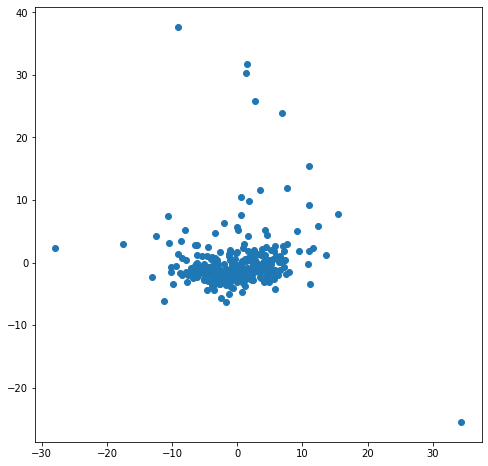

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(norm_feats[:,0], norm_feats[:,1])
plt.show()

# Do the Clustering

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cosine as cosine_dist
from sklearn.cluster import AgglomerativeClustering

In [24]:
def plot_hc(feats, labels, out_fp=None):
    # Perform the Hierarchical Clustering
    d_list = linkage(feats, 'average', metric="cosine")

    # Calculate the Cophenetic Correlation Coefficient
    c, coph_dists = cophenet(d_list, pdist(feats))
    print("Cophenetic Correlation Coefficient: {}".format(c))

    # Do the actual plotting.
    fig, ax = plt.subplots(figsize=(12,12))
    
    dendrogram(
        d_list,
        leaf_rotation=0,  # rotates the x axis labels
        leaf_font_size=14,  # font size for the x axis labels
        labels = labels, 
        ax=ax,
        color_threshold=0
    )
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel("Users", fontsize=14)
    ax.set_ylabel("Cosine Distance", fontsize=14)
    ax.grid()
    
    plt.tight_layout()
    if out_fp is not None:
        fig.savefig(out_fp)

Cophenetic Correlation Coefficient: 0.2694086541269237


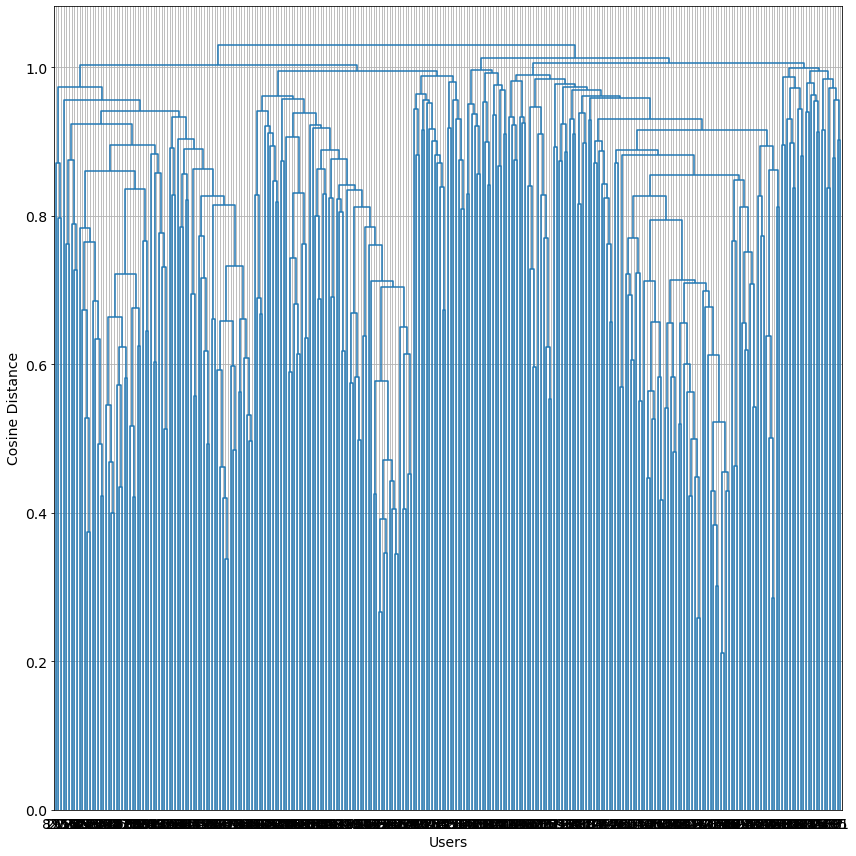

In [25]:
plot_hc(norm_feats, user_toks.index.astype(int), out_fp=None)#os.path.join(GRAPH_DIR, f"dendrogram_{curr_feat_type}.pdf"))

In [26]:
%%time
for i in range(2,10):
    model = AgglomerativeClustering(n_clusters=i, affinity='cosine', linkage='average')  
    clusters = model.fit_predict(norm_feats)
    avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters, metric="cosine")
    print(f"Average silhoette score for {i} clusters:\t", avg_silhouette_score, "\n")

Average silhoette score for 2 clusters:	 0.06639849502130284 

Average silhoette score for 3 clusters:	 0.047267604479053295 

Average silhoette score for 4 clusters:	 0.045351865854126205 

Average silhoette score for 5 clusters:	 0.05425026900441798 

Average silhoette score for 6 clusters:	 0.05125051726763838 

Average silhoette score for 7 clusters:	 0.0489117894670944 

Average silhoette score for 8 clusters:	 0.050064669731200294 

Average silhoette score for 9 clusters:	 0.049599041758778356 

Wall time: 78 ms


In [27]:
%%time
sil_scores = []
for i in range(2,len(user_toks)):
    model = AgglomerativeClustering(n_clusters=i, affinity='cosine', linkage='average')  
    clusters = model.fit_predict(norm_feats)
    sil_scores.append(metrics.silhouette_score(norm_feats, clusters, metric="cosine"))

Wall time: 2.83 s


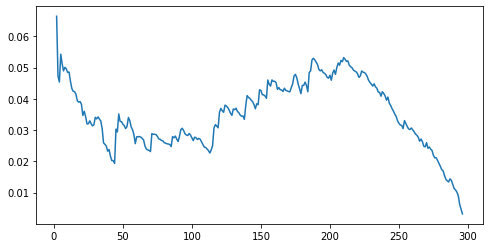

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(list(range(2, len(user_toks))), sil_scores)
plt.show()

In [29]:
model = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average')  
clusters1 = model.fit_predict(norm_feats)

In [30]:
for clust in set(clusters1):
    print(f"Num users in Cluster {clust}: {len(user_toks[clusters1==clust].index)}")

Num users in Cluster 0: 142
Num users in Cluster 1: 155


In [31]:
for clust in set(clusters1):
    print(f"Num words in Cluster {clust}: {len(merge_lists(user_toks[clusters1==clust]))}")

Num words in Cluster 0: 2176632
Num words in Cluster 1: 3815206


In [32]:
for clust in set(clusters1):
    print(f"Avg words in Cluster {clust}: {user_toks[clusters1==clust].apply(len).mean():.0f}")
    print(f"Median words in Cluster {clust}: {user_toks[clusters1==clust].apply(len).median():.0f}")
    print()

Avg words in Cluster 0: 15328
Median words in Cluster 0: 3442

Avg words in Cluster 1: 24614
Median words in Cluster 1: 7718



In [33]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=1, affinity='cosine', linkage='average')  
clusters2 = model.fit_predict(norm_feats)

In [34]:
for clust in set(clusters2):
    print(f"Num users in Cluster {clust}: {len(user_toks[clusters2==clust].index)}")

Num users in Cluster 0: 23
Num users in Cluster 1: 80
Num users in Cluster 2: 16
Num users in Cluster 3: 103
Num users in Cluster 4: 75


In [35]:
for clust in set(clusters2):
    print(f"Num words in Cluster {clust}: {len(merge_lists(user_toks[clusters2==clust]))}")

Num words in Cluster 0: 18790
Num words in Cluster 1: 1905951
Num words in Cluster 2: 12337
Num words in Cluster 3: 2145505
Num words in Cluster 4: 1909255


In [36]:
for clust in set(clusters2):
    print(f"Avg words in Cluster {clust}: {user_toks[clusters2==clust].apply(len).mean():.0f}")
    print(f"Median words in Cluster {clust}: {user_toks[clusters2==clust].apply(len).median():.0f}")
    print()

Avg words in Cluster 0: 817
Median words in Cluster 0: 716

Avg words in Cluster 1: 23824
Median words in Cluster 1: 5250

Avg words in Cluster 2: 771
Median words in Cluster 2: 364

Avg words in Cluster 3: 20830
Median words in Cluster 3: 7608

Avg words in Cluster 4: 25457
Median words in Cluster 4: 8987



In [37]:
clusters = clusters1

In [38]:
avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters, metric="cosine")
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Normed:	 0.06639849502130284 



In [39]:
for clust in set(clusters):
    print(clust, len(user_toks[clusters==clust].index))

0 142
1 155


In [40]:
print(",".join(map(str, user_toks[user_toks.index.isin(top_20.index)].index)))
print(",".join(map(str, clusters[user_toks.index.isin(top_20.index)])))

2.0,16.0,32.0,38.0,62.0,99.0,315.0,376.0,464.0,706.0,709.0,775.0,843.0,1206.0,1342.0,1423.0,1448.0,1500.0,1584.0,1804.0
0,0,0,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0


In [41]:
for i, (c1, c2) in enumerate(zip(clusters[user_toks.index.isin(top_20.index)], clusters2[user_toks.index.isin(top_20.index)])):
    print(i, c1, c2, sep=",")

0,0,3
1,0,3
2,0,3
3,1,4
4,0,3
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1
10,1,4
11,0,3
12,0,3
13,0,3
14,1,1
15,1,4
16,1,4
17,1,1
18,1,1
19,0,3


In [42]:
ling_clusts = {"Cluster 0": list(user_toks[clusters1==0].index), 
               "Cluster 1": list(user_toks[clusters1==1].index)}

with open(os.path.join(GRAPH_DIR, f"{curr_feat_type}_core_clusts.json"), "w") as out_file:
    json.dump(ling_clusts, out_file)

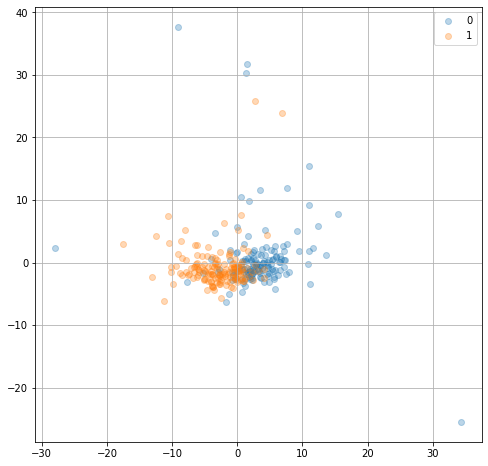

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
for c in set(clusters):
    ax.scatter(norm_feats[clusters==c,0], norm_feats[clusters==c,1], label=c, alpha=0.3)
ax.grid()
ax.legend()
plt.show()

# Analyse Spread Across Users

In [44]:
user_toks.index[clusters==0]

Float64Index([   2.0,    3.0,    4.0,    5.0,    7.0,    9.0,   11.0,   14.0,
                15.0,   16.0,
              ...
              1991.0, 2007.0, 2010.0, 2015.0, 2105.0, 2144.0, 2149.0, 2184.0,
              2207.0, 2218.0],
             dtype='float64', name='poster_id', length=142)

In [45]:
user_toks.index[clusters==1]

Float64Index([   1.0,   18.0,   20.0,   23.0,   35.0,   36.0,   38.0,   39.0,
                44.0,   48.0,
              ...
              2163.0, 2166.0, 2167.0, 2195.0, 2222.0, 2223.0, 2236.0, 2243.0,
              2259.0, 2282.0],
             dtype='float64', name='poster_id', length=155)

In [46]:
contingency1 = pd.crosstab(user_toks.index.values, [clusters1], rownames=["User"], colnames=["Cluster"])
contingency2 = pd.crosstab(user_toks.index.values, [clusters2], rownames=["User"], colnames=["Cluster"])

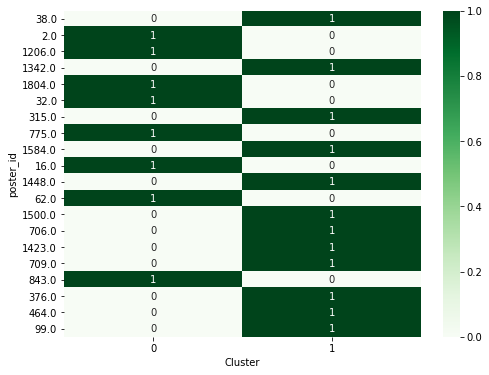

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(contingency1.loc[top_20.index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

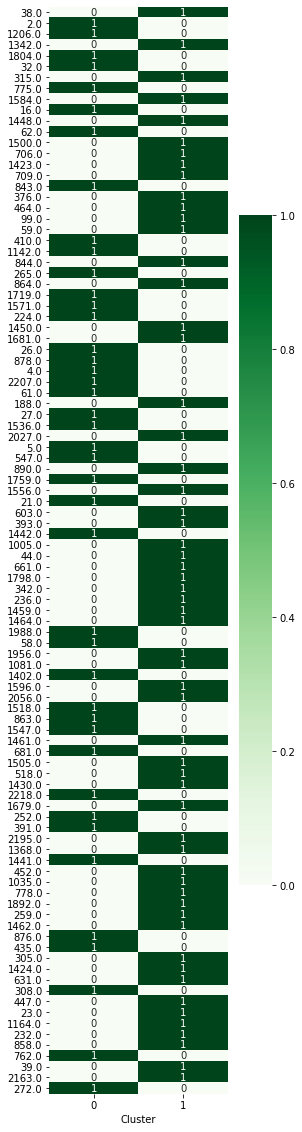

In [48]:
fig, ax = plt.subplots(figsize=(4,20))
sns.heatmap(contingency1.loc[posts_per_user.sort_values(ascending=False).head(100).index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

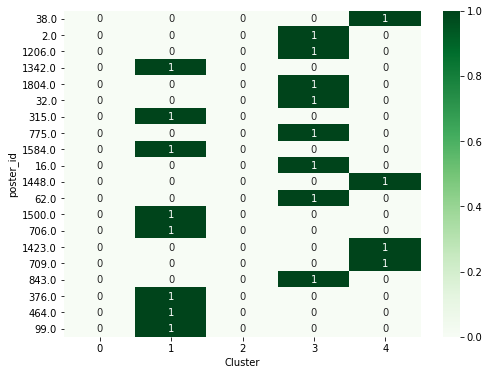

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(contingency2.loc[top_20.index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

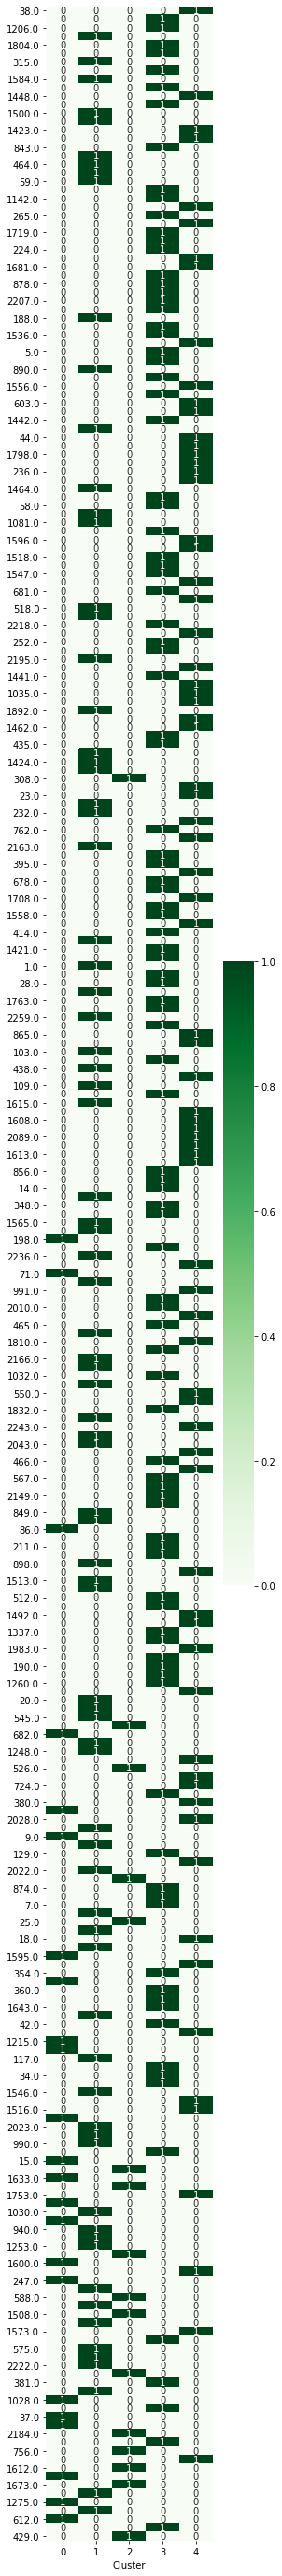

In [50]:
fig, ax = plt.subplots(figsize=(4,50))
sns.heatmap(contingency2.loc[posts_per_user.sort_values(ascending=False).index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

# Compare clusters

In [51]:
clust_comparison = pd.crosstab(clusters1, [clusters2], rownames=["Clust 1"], colnames=["Clust 2"])

In [52]:
clust_comparison

Clust 2,0,1,2,3,4
Clust 1,,,,,
0,23,0,16,103,0
1,0,80,0,0,75


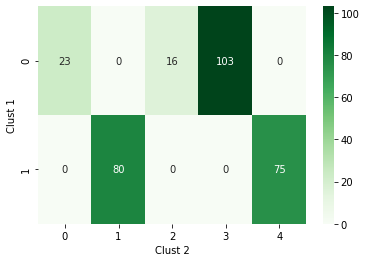

In [53]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(clust_comparison, annot=True, ax=ax, fmt='g', cmap="Greens")
plt.show()

# Get Some Keywords Between Clusters

In [54]:
%%time
lr = lambda x, y: np.log2(x / y)

def get_cluster_keywords(tokens, clusters):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
        lrs = pd.Series(lrs).sort_values(ascending=False)
        t10_lr = lrs.head(20)
        b10_lr = lrs.tail(20)

        print(clust)
        print("-------------------------------------------------------------------------------------")
        for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
            print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
        print("-------------------------------------------------------------------------------------")

Wall time: 0 ns


In [55]:
def get_cluster_lrs(tokens, clusters, min_freq=100):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}
    
    clust_kw = dict()

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > min_freq}
        lrs = pd.Series(lrs).sort_values(ascending=False)
   
        clust_kw[clust] = lrs
    return clust_kw

# Key features (2 clusters)

In [56]:
clusters = clusters1

## Key PoS-Trigrams

In [57]:
%%time
get_cluster_keywords(pos_trigrams, clusters)

0
-------------------------------------------------------------------------------------
ADV_INTJ_PUNCT      	      1.38	|	PROPN_PROPN_NOUN    	     -1.45
INTJ_VERB_ADP       	      1.34	|	ADP_ADV_NUM         	     -1.49
INTJ_PUNCT_AUX      	      1.33	|	PROPN_PROPN_CCONJ   	     -1.49
AUX_PUNCT_INTJ      	      1.27	|	PROPN_PROPN_PROPN   	     -1.50
PRON_ADV_PART       	      1.22	|	PUNCT_PUNCT_X       	     -1.56
PART_ADJ_PRON       	      1.18	|	PUNCT_NUM_SYM       	     -1.56
INTJ_PUNCT_SCONJ    	      1.15	|	PUNCT_PROPN_PROPN   	     -1.61
PRON_PART_ADV       	      1.11	|	PROPN_PUNCT_PROPN   	     -1.68
PRON_INTJ_VERB      	      1.11	|	NUM_SYM_NUM         	     -1.71
INTJ_INTJ_PUNCT     	      1.10	|	NOUN_PROPN_PROPN    	     -1.72
ADJ_ADV_PRON        	      1.10	|	PUNCT_PROPN_ADP     	     -1.75
ADV_ADJ_PRON        	      1.09	|	PROPN_PROPN_ADP     	     -1.79
INTJ_PUNCT_ADJ      	      1.08	|	PROPN_ADP_PROPN     	     -1.80
ADV_INTJ_VERB       	      1.07	|	SYM_NUM_NOUN        

In [58]:
get_text_example_of_pos(["PUNCT", "INTJ", "INTJ"], 
                        user_pos[clusters==0], 
                        user_toks[clusters==0], 
                        doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 247:
2.0        ouncilors have voting privileges now . uh oh , fixed . gah. fixed . well , that w
2.0         i . live up to your own standards . hell yeah . or we could use lulu , like tint
2.0        possible is considerably harder than " oh no , it takes effort " all us dollars a
2.0        ave breasts . my chest is very flat . hi fogo4 , thanks for stopping by . this cla
2.0        inal claim from the very same page ) : oh my . you did n't think it magically tra
2.0        , and then you 'd probably say that " oh well , they were pretty close to speakin
2.0        warning to this effect will follow . hi hoopera , thanks for stopping by . i hope 
2.0        ermines what i said or did n't say ? gosh darn it , why was n't i informed !? i a
2.0        now , falsity implies all statements . oh my . perhaps you should n't have used t
2.0         piece of very anecdotal evidence . hi sandokhan , i will repeat this to you once 
2.0         tried denying that your position

In [59]:
%%time
concs = make_pos_concordance(["NUM", "PROPN", "NUM"],
                             user_pos[clusters==1],
                             user_toks[clusters==1],
                             doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
18.0       3
38.0      11
59.0      17
65.0       1
85.0      28
99.0       3
103.0      2
155.0      4
232.0      7
236.0      1
315.0     71
376.0      1
511.0      1
603.0      2
704.0      1
709.0      1
713.0      1
844.0      1
864.0      3
1253.0     7
1342.0    20
1424.0     2
1448.0     4
1459.0     2
1500.0     8
1584.0    11
2166.0     1
2222.0     3
dtype: int64

Mean uses per user:	 7.75
Median uses per user:	 3.0
Wall time: 2.61 s


## Key words

In [60]:
%%time
get_cluster_keywords(user_toks, clusters)

0
-------------------------------------------------------------------------------------
fora                	      4.79	|	90                  	     -1.40
refrain             	      4.34	|	rotation            	     -1.41
warned              	      4.17	|	pole                	     -1.42
ranting             	      3.10	|	flight              	     -1.44
youâ              	      3.05	|	northern            	     -1.49
re                 	      2.98	|	west                	     -1.49
warning             	      2.83	|	measurement         	     -1.50
gon                 	      2.82	|	radius              	     -1.52
reers               	      2.79	|	navigation          	     -1.57
ban                 	      2.71	|	refraction          	     -1.58
angry               	      2.70	|	12                  	     -1.59
strawman            	      2.65	|	southern            	     -1.59
demonstrably        	      2.50	|	equator             	     -1.66
na                  	      2.45	|	south               

In [61]:
%%time
clust_lrs = get_cluster_lrs(user_toks, clusters)

Wall time: 2.08 s


In [62]:
(clust_lrs[0]["re'ers"])

1.8569691576906135

In [63]:
(clust_lrs[0]["reers"])

2.78910212042994

In [64]:
clust_lrs[1]["fe'ers"]

0.24425910399104284

In [65]:
clust_lrs[0]["feers"]

0.5768993375033704

In [66]:
clust_lrs[0]["flat"]

-0.1809515302916275

In [67]:
clust_lrs[0]["round"]

0.23209197872405468

In [68]:
c1 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 365 / 2176632
Cluster 1: 581 / 3815206


0.1397556573914757

In [69]:
c1 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 166 / 2176632
Cluster 1: 103 / 3815206


1.495554852484194

In [70]:
get_ngram_example(["fe'ers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 203:
2.0        ts in which " theory " may be used by fe'ers . within the context of " conspiracy 
2.0        s used in exactly the same fashion by fe'ers as other scientists , by way of provi
2.0        y be correct if he simply spoke to no fe'ers at all . personally , i propose that 
2.0        t large . that is not a claim serious fe'ers would make , in my humble opinion . p
2.0        ct and following the more influential fe'ers online . in other words : yes , but y
2.0        hat the most - supported map is among fe'ers . could you just go away now ? how do
2.0        uld be silly . rowbotham 's and other fe'ers ' experiments are reproducible . rabi
2.0        ised for some of the more belligerent fe'ers which appeared to target him at the t
2.0        ace in the few . yes , there are some fe'ers who are working on alternative models
2.0        olly , we sure showed those gosh darn fe'ers ! " engaging with them is an utter wa
2.0        gestions have garnered cri

In [71]:
get_ngram_example(["flat", "earthers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 365:
2.0        er well . unfortunately , not all flat earthers are zeteticists , and we do have 
2.0         comments from round earthers and flat earthers alike , i would like to ask every
2.0         answering questions on behalf of flat earthers , especially if you 're going to 
2.0        . a bunch of the things you say " flat earthers " claim simply do not apply to th
2.0        ng something along the lines of " flat earthers claim that 2+2=5 and that is wron
2.0        ere , welcome to the forum . most flat earthers are primarily concerned with the 
2.0        nestly do n't think there are any flat earthers here who would claim california a
2.0        up a relatively small minority of flat earthers , very far from your alleged " al
2.0        way to carry on doing his thing . flat earthers ( or fe'ers for short ) is the mo
2.0        adbible ( click ) 21/08/2017 what flat earthers are saying about the total solar 
2.0         global news ( click ) 30/10/2017 fl

# Key features (cosine dist < 1 clusters)

In [72]:
clusters = clusters2

In [73]:
%%time
get_cluster_keywords(pos_trigrams, clusters)

0
-------------------------------------------------------------------------------------
AUX_ADJ_PUNCT       	      0.88	|	VERB_ADP_DET        	      0.19
NOUN_PUNCT_ADV      	      0.42	|	DET_NOUN_PUNCT      	      0.17
DET_NOUN_VERB       	      0.42	|	PRON_VERB_DET       	      0.17
ADP_NOUN_PUNCT      	      0.39	|	ADP_DET_ADJ         	      0.13
NOUN_PUNCT_CCONJ    	      0.35	|	NOUN_PUNCT_PRON     	      0.09
NOUN_AUX_VERB       	      0.32	|	PUNCT_DET_NOUN      	      0.06
DET_NOUN_AUX        	      0.27	|	VERB_DET_NOUN       	      0.05
ADJ_NOUN_PUNCT      	      0.24	|	PUNCT_PRON_AUX      	      0.01
VERB_ADP_DET        	      0.19	|	DET_ADJ_NOUN        	      0.01
DET_NOUN_PUNCT      	      0.17	|	NOUN_ADP_NOUN       	      0.01
PRON_VERB_DET       	      0.17	|	AUX_VERB_ADP        	     -0.04
ADP_DET_ADJ         	      0.13	|	ADP_DET_NOUN        	     -0.05
NOUN_PUNCT_PRON     	      0.09	|	PUNCT_PRON_VERB     	     -0.07
PUNCT_DET_NOUN      	      0.06	|	DET_NOUN_ADP        

In [74]:
%%time
get_cluster_keywords(user_toks, clusters)

0
-------------------------------------------------------------------------------------
?                   	      0.90	|	this                	      0.22
would               	      0.54	|	be                  	      0.21
earth               	      0.46	|	,                   	      0.17
i                   	      0.38	|	as                  	      0.15
but                 	      0.29	|	if                  	      0.14
are                 	      0.27	|	in                  	      0.13
this                	      0.22	|	.                   	      0.12
be                  	      0.21	|	is                  	      0.09
,                   	      0.17	|	the                 	      0.02
as                  	      0.15	|	it                  	     -0.04
if                  	      0.14	|	a                   	     -0.04
in                  	      0.13	|	"                   	     -0.07
.                   	      0.12	|	and                 	     -0.07
is                  	      0.09	|	not                 